In [252]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [322]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [255]:
original_df = pd.read_csv("reviews.csv.gz", compression="gzip")
df = pd.read_csv("reviews.csv.gz", compression="gzip")

In [256]:
df.describe(include='all')

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
count,47894.000000,44544,43567,48136,48136,47952,4.813600e+04,48116.000000,48133,48136,48136,48136,48136.000000,48136.000000,40594
unique,NaN,7,95,62,3,24,NaN,NaN,8,2120,41417,47935,NaN,NaN,173
top,NaN,hourglass,34b,dress,fit,"5' 4""",NaN,NaN,wedding,"June 15, 2016",b'Stylist Review',b'.',NaN,NaN,130lbs
freq,NaN,13887,6732,23179,35430,7100,NaN,NaN,14411,208,230,18,NaN,NaN,3576
mean,33.866580,NaN,NaN,NaN,NaN,NaN,1.043875e+06,9.084255,NaN,NaN,NaN,NaN,12.248255,499091.944470,NaN
std,8.018446,NaN,NaN,NaN,NaN,NaN,8.067556e+05,1.436092,NaN,NaN,NaN,NaN,8.523070,288853.095706,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,1.233730e+05,2.000000,NaN,NaN,NaN,NaN,0.000000,47.000000,NaN
25%,29.000000,NaN,NaN,NaN,NaN,NaN,1.941820e+05,8.000000,NaN,NaN,NaN,NaN,8.000000,249516.000000,NaN
50%,32.000000,NaN,NaN,NaN,NaN,NaN,9.458800e+05,10.000000,NaN,NaN,NaN,NaN,12.000000,498811.000000,NaN
75%,37.000000,NaN,NaN,NaN,NaN,NaN,1.678888e+06,10.000000,NaN,NaN,NaN,NaN,16.000000,749178.750000,NaN


<h1>Introduction</h1>
<p>Clearly, there are many null values within the dataset. I will be varying how to handle these null values differently depending on the feature. These rules are as follows:</p>
<ul>
    <li>If less than 20% of data in feature is NaN: Work with it</li>
    <li>If more than 40% of data in feature is NaN: Delete Feature. It's too plagued with Nulls</li>
    <li>If in between these values, use common sense to reason the solution</li>
</ul>

In [257]:
df.dtypes

age               float64
body type          object
bust size          object
category           object
fit                object
height             object
item_id             int64
rating            float64
rented for         object
review_date        object
review_summary     object
review_text        object
size                int64
user_id             int64
weight             object
dtype: object

In [258]:
df.isnull().sum()

age                242
body type         3592
bust size         4569
category             0
fit                  0
height             184
item_id              0
rating              20
rented for           3
review_date          0
review_summary       0
review_text          0
size                 0
user_id              0
weight            7542
dtype: int64

In [259]:
# Assume you must be over 18 to consent to having your data
df = (df[df['age'] > 18.0]).copy()
df.reset_index(drop=True, inplace=True)

<h1>Height</h1>
<p>Height feature should be a numeric value. I change this feature into a float representing inches below.</p>

In [260]:
df.height

0        5' 6"
1        5' 6"
2        5' 5"
3        5' 2"
4        5' 3"
         ...  
47721    5' 4"
47722    5' 7"
47723    5' 6"
47724    5' 7"
47725    6' 1"
Name: height, Length: 47726, dtype: object

In [261]:
# Convert heights from a string type with feet and inches to a float type of total inches
def changeHeights(x):
    if type(x) != float:
        return x.replace(x, str(int(x[0])*12 + int(x[3])))
    else:
        return x

df.height = df.height.apply(lambda x: changeHeights(x))
df.height.astype(float)

0        66.0
1        66.0
2        65.0
3        62.0
4        63.0
         ... 
47721    64.0
47722    67.0
47723    66.0
47724    67.0
47725    73.0
Name: height, Length: 47726, dtype: float64

<h1>Fit</h1>

In [262]:
df['fit']

0          fit
1        large
2          fit
3          fit
4          fit
         ...  
47721      fit
47722      fit
47723      fit
47724      fit
47725      fit
Name: fit, Length: 47726, dtype: object

<p>fit can be rearranged into a binary nominal set. {fit, not-fit}. I tried this but it did not improve the accuracy at all. As a result I left it.</p>

<h2>Investigating if changing item_id to a nominal value will improve accuracy.</h2>
<p>In my opinion, item_id should be treated as a nominal value over numeric for the following reasons:</p>
<li>Items 1 digit apart are just as different as items 1000 digits apart</li>
<li>Item_ID would not make sense for non integer values eg. 5.5</li>
<li>It appears that Item ID's can be used to catagorize the dataset, rather than be interpreted as a numeric value, that can increase and decrease appropriately</li>

In [263]:
len(df['item_id'].unique())

5006

In [264]:
df['item_id'] = df['item_id'].astype(str)

<h1>Dress Size</h1>
<p>From researching dress sizes, and asking the few women I am able to talk to, I have found an International Single Size Conversion System for dress sizes. It seems that dress inputs vary from US, UK and EU measurements</p>

<p>UK	4	6	8	10	12	14	16	18	20	22	24	26	<br/>European	32	34	36	38	40	42	44	46	48	50	52	54	<br>US	1	2	4	6	8	10	12	14	16	18	20	22</p>

<p>There is no way to differentiate between UK and US sizes, unless we incorporate the size proportions into the calculation. This will be looked at later on.</p>

<h2>Bra Size Conversions:</h2>
32DD = 32DD/E<br>
32E = 32DDD/F<br>
32F = 32G<br>
34DD = 34DD/E<br>
34E = 34DDD/F<br>
34F = 34G<br>
etc....


In [265]:
df['bust size'] = df['bust size'].str.replace('ddd/e', 'dd', regex=True)
df['bust size'] = df['bust size'].str.replace('ddd/f', 'e', regex=True)
df['bust size'] = df['bust size'].str.replace('g', 'f', regex=True)

In [266]:
df['bust size'].unique()

array(['32dd', '36d', '34b', '38b', '34c', '36c', '32b', '36aa', '32c',
       '36b', '34dd', '32d', '34d', '36a', nan, '38dd', '34a', '38d',
       '38c', '38d+', '36dd', '34d+', '32d+', '32a', '36d+', '30dd',
       '34f', '40dd', '28a', '34h', '36h', '32f', '30c', '34aa', '44b',
       '30d', '36f', '28dd', '32aa', '40d', '30b', '38a', '30a', '44f',
       '46c', '32h', '38f', '42f', '28c', '42dd', '42d', '40f', '28aa',
       '30f', '28d', '42b', '40c', '42c', '42h', '44dd', '38aa', '30h',
       '38h', '40b', '36i', '28b', '34j', '44d', '34i', '40h', '40i',
       '30i', '32j', '38i', '28f', '36j', '30aa', '44c', '38j'],
      dtype=object)

In [267]:
# 'aa' values look like typos so:
df['bust size'] = df['bust size'].str.replace('aa', 'a', regex=True)

<p>From online research, it does not seem like 38d+, 32d+, etc. are valid bra sizes. Instead I will include them in the appropriate dd bra size category</p>

In [268]:
df['bust size'] = df['bust size'].str.replace('+', 'd', regex=True)

<h1>Weight</h1>

In [269]:
# Percentage
(df[df['weight'].isnull()].user_id.count() / df.shape[0]) * 100

15.412982441436535

<h3>Interpretation</h3>
<p>15.412% of the weight dataset is null. We want to reduce this to 0. My approach will be removing the row with, for example: weight and another feature are null. This will result in solving missing feature from more than 1 feature in one deletion. Once we get around 10% missing values, I'm going to fill in the rest with mean/mode average values.</p>

In [270]:
df[(df['weight'].isnull()) & df['body type'].isnull()].user_id.count() / df.shape[0] * 100

2.832837447093827

In [271]:
df[(df['weight'].isnull()) & df['bust size'].isnull()].user_id.count() / df.shape[0] * 100

3.968486778695051

In [272]:
df[(df['weight'].isnull()) & df['body type'].isnull()  & df['bust size'].isnull()].user_id.count() / df.shape[0] * 100

1.0748858064786488

In [273]:
df[(df['weight'].isnull()) & df['height'].isnull()].user_id.count() / df.shape[0] * 100

0.140384695972845

In [274]:
new_df = (df[(df['weight'].notnull()) | (df['body type'].notnull())]).copy()

In [275]:
new_df = (new_df[(new_df['weight'].notnull()) | (new_df['bust size'].notnull())])

In [276]:
new_df = (new_df[(new_df['weight'].notnull()) | (new_df['age'].notnull())])

In [277]:
new_df = (new_df[(new_df['weight'].notnull()) | (new_df['height'].notnull())])

In [278]:
new_df.shape[0] / df.shape[0]

0.9421908393747643

In [279]:
# Percentage of null values
(new_df[new_df['weight'].isnull()].user_id.count() / new_df.shape[0]) * 100

10.223052460693397

In [280]:
df = new_df

In [281]:
# Convert weights from a string type with lbs to a float type pounds
def removeLbs(x):
    if type(x) != float:
        return x.replace('lbs', '')
    else:
        return x
    


df.weight = df.weight.apply(lambda x: removeLbs(x))
df.weight = df.weight.astype(float)

In [282]:
df_null_weights = df[df['weight'].isnull()]

df.dropna(subset=["weight"], inplace=True)
df.reset_index(drop=True, inplace=True)


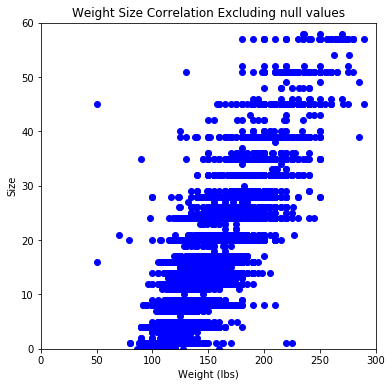

In [283]:
weight = df['weight']
size = df['size']

fig = plt.figure(figsize=(6,6))
plt.title("Weight Size Correlation Excluding null values")
plt.scatter(weight, size, color = "blue", marker="o")
plt.xlabel("Weight (lbs)")
plt.xlim(0, 300.0)
plt.ylabel("Size")
plt.ylim(0, 60)
plt.show()

<h3>Objective</h3>
<p>From research of dress sizes, it seems there is a mix of UK and US dress sizes. Due to the huge overlap of dress size values between UK and US dresses, I decided to graph the size with the weight values, and remove the outliers. Here I assume that as the weight increases, so does the dress size.</p>

In [284]:
outliers = df[((df['weight'] > 260.0) & (df['size'] <= 50.0)) 
                  | ((df['weight'] <= 100.0) & (df['size'] >= 15.0))
                  | ((df['weight'] <= 140.0) & (df['size'] >= 35.0))
                  | ((df['weight'] >= 182.0) & (df['size'] <= 9.0))
                 ]

In [285]:
df = df[~df.isin(outliers)]

df.dropna(subset=["size"], inplace=True)
df.reset_index(drop=True, inplace=True)


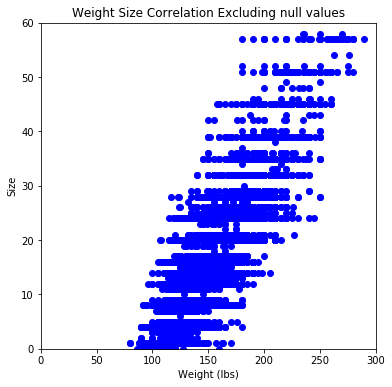

In [286]:
weight = df['weight']
size = df['size']

fig = plt.figure(figsize=(6,6))
plt.title("Weight Size Correlation Excluding null values")
plt.scatter(weight, size, color = "blue", marker="o")
plt.xlabel("Weight (lbs)")
plt.xlim(0, 300.0)
plt.ylabel("Size")
plt.ylim(0, 60)
plt.show()

<h2>Result</h2>
<p>As you can see, the outliers from weight and size have been removed. There is now a very strong correlation between weight and dress sizes which should be true.</p>

In [287]:
# add the 10% of null values back. These will be converted to the mean average
df = df.append(df_null_weights)

In [288]:
df.dropna(subset=["rented for"], inplace=True)
df.reset_index(drop=True, inplace=True)


In [289]:
df.dropna(subset=["rating"], inplace=True)
df.reset_index(drop=True, inplace=True)


<h1>Creating the Learning Algorithm</h1>

In [327]:
numeric_features = ['age', 'weight', 'size', 'height']
tfidf_nominal_features = ['body type', 'bust size', 'category', 'fit', 'item_id', 
                    'rented for', 'user_id']
nominal_features = ['body type', 'bust size', 'category', 'fit', 'item_id', 
                    'rented for', 'user_id', 'review_text']


In [328]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [335]:
tfidf_preprocessor = ColumnTransformer([
("num", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
("scaler", StandardScaler())]),numeric_features),
("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
("binarizer", OneHotEncoder(handle_unknown="ignore"))]),tfidf_nominal_features),
('tfidf', TfidfVectorizer(), 'review_text')],
remainder="drop")

PCA_preprocessor = ColumnTransformer([
("num", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
("scaler", PCA(n_components=0.9))]),numeric_features),
("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
("binarizer", OneHotEncoder(handle_unknown="ignore"))]),nominal_features)],
remainder="drop")

In [292]:
preprocessor = ColumnTransformer([
("num", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
("scaler", StandardScaler())]),numeric_features),
("nom", Pipeline([("imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
("binarizer", OneHotEncoder(handle_unknown="ignore"))]),nominal_features)],
remainder="drop")

In [336]:
tfidf_pipeline = Pipeline([
("pre", tfidf_preprocessor),
("est", LinearRegression())])

PCA_pipeline = Pipeline([
("pre", PCA_preprocessor),
("est", LinearRegression())
])

In [294]:
pipeline = Pipeline([
("pre", preprocessor),
("est", LinearRegression())])

In [295]:
y = df['rating'].values

In [296]:
df.dtypes

age               float64
body type          object
bust size          object
category           object
fit                object
height             object
item_id            object
rating            float64
rented for         object
review_date        object
review_summary     object
review_text        object
size              float64
user_id           float64
weight            float64
dtype: object

In [297]:
len(df['user_id'].unique())

34287

In [298]:
len(df['user_id'])

44920

In [299]:
# change user ID to string and represent it as nominal. This is because users should be represented catagorically
# rather than numerically
df['user_id'] = df['user_id'].astype(str)

In [300]:
df['user_id'][0]

'427200.0'

In [ ]:
np.mean(cross_val_score(tfidf_pipeline, df, y, scoring="neg_mean_absolute_error", cv=10))

In [ ]:
dum_classifier = DummyClassifier(strategy="stratified")

np.mean(cross_val_score(dum_classifier, df, y, scoring="neg_mean_absolute_error", cv=10))

<p>Dummy: -1.3125113075457286</p>
<p>With TF/IDF Vectorizer: -1.0755387</p>
<p>With PCA: 1.0757289671527315</p>
<p>Without TF/IDF Vectorizer or PCA: -1.0755387</p>
<p>As a result, the end function is an improvement on the Dummy funciton, which means it is a useful method for predicting the ratings of dresses.</p>

In [309]:
df.shape

(44920, 15)

In [311]:
df_new = SelectKBest(chi2, k=10)

In [312]:
df_new

SelectKBest(k=10, score_func=<function chi2 at 0x7f36d0fdf2f0>)

In [314]:
count_vect = CountVectorizer()

In [315]:
test = count_vect.fit_transform(df['review_text'])